# DATA 608 Group Project

In [1]:
import os
import random
import shutil
import glob
import pathlib
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [3]:
# Import and adjust matplotlib dpi scaling for high res displays
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [4]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1



In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12842985965146626436
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18088123837582950070
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


## Load in Data

In [6]:
data_dir = pathlib.Path("G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Images")
data = {"f": [], "x": [], "y": []}

for directory in data_dir.iterdir(): 
    for f in directory.iterdir():
        if f.suffix == ".jpg":
            data["f"].append(f)
            data["x"].append(str(f))
            data["y"].append(str(f).split('\\')[-2])
            
df = pd.DataFrame(data=data)
uncertain_df = df.loc[(df['y'] == 'Uncertain')]
df = df.drop(df[df.y == 'Uncertain'].index)
df = df.drop(df[df.y == 'Irregular'].index)
df = df.sample(frac=0.6).reset_index(drop=True)
df

,f,x,y
0,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral
1,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral
2,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral
3,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Elliptical
4,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral
...,...,...,...
69121,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral
69122,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral
69123,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Elliptical
69124,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Spiral


In [7]:
#uncertain_df = df.loc[(df['y'] == 'Uncertain')]
uncertain_df

,f,x,y
115213,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
115214,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
115215,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
115216,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
115217,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
...,...,...,...
239566,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
239567,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
239568,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain
239569,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain


In [8]:
def ConvBlock(layers, model, filters):
    '''
    '''
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, (3,3), activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

def FCBlock(model):
    '''
    '''
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    '''
    '''
    #TARGET_SIZE = (212, 212)
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [9]:
model = VGG_16()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 106, 106, 3)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 108, 108, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 106, 106, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 108, 108, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 55, 55, 64)        0

In [10]:
optimizer = Adam(lr = 1*10**-6) #RMSprop(lr = 1*10**-6) SGD(lr = 1*10**-6)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
#optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] mean_squared_error

In [11]:
TARGET_SIZE = (106, 106) # Downsample to 106
batch_size = 32
steps_to_take = int((2/3)*len(df)/batch_size)
val_steps_to_take = int((1/3)*len(df)/batch_size)

# img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res

training_gen = ImageDataGenerator(
    rescale = 1/255.,
    shear_range = 0.2,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 1/3)

training_flow = training_gen.flow_from_dataframe(
    dataframe = df,
    x_col = "x",
    y_col = "y",
    batch_size = batch_size,
    target_size = TARGET_SIZE,
    class_mode = "binary",
    subset = "training")

validation_flow = training_gen.flow_from_dataframe(
    dataframe = df,
    x_col = "x",
    y_col = "y",
    batch_size = batch_size,
    target_size = TARGET_SIZE,
    class_mode = "binary",
    subset = "validation")

Found 46084 validated image filenames belonging to 2 classes.
Found 23042 validated image filenames belonging to 2 classes.


### Train Model

In [12]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(filepath = 'tmp/weights.hdf5', verbose = 1, save_best_only = True)


history = model.fit(training_flow, steps_per_epoch = steps_to_take,
                    validation_data = validation_flow, validation_steps = val_steps_to_take,
                    epochs = 25, callbacks = [early_stopping]) # shuffle=True

#nb_epoch=5 , verbose = 2
#samples_per_epoch = steps_to_take, nb_val_samples = val_steps_to_take
#callbacks=[history,checkpointer,early_stopping]
#loss = 'binary_crossentropy', metrics = ['accuracy']

Epoch 1/25
1440/1440 [==============================] - 350s 240ms/step - loss: 0.6006 - accuracy: 0.7026 - val_loss: 0.2749 - val_accuracy: 0.8944
Epoch 2/25
1440/1440 [==============================] - 300s 208ms/step - loss: 0.2191 - accuracy: 0.9163 - val_loss: 0.1532 - val_accuracy: 0.9431
Epoch 3/25
1440/1440 [==============================] - 299s 208ms/step - loss: 0.1407 - accuracy: 0.9497 - val_loss: 0.1135 - val_accuracy: 0.9602
Epoch 4/25
1440/1440 [==============================] - 299s 208ms/step - loss: 0.1135 - accuracy: 0.9588 - val_loss: 0.1032 - val_accuracy: 0.9619
Epoch 5/25
1440/1440 [==============================] - 300s 208ms/step - loss: 0.1064 - accuracy: 0.9612 - val_loss: 0.1135 - val_accuracy: 0.9609
Epoch 6/25
1440/1440 [==============================] - 299s 208ms/step - loss: 0.0927 - accuracy: 0.9677 - val_loss: 0.0835 - val_accuracy: 0.9699
Epoch 7/25
1440/1440 [==============================] - 300s 208ms/step - loss: 0.0863 - accuracy: 0.9687 - val_

In [13]:
model.save("G:/Files/Ryan's/Local/Documents/GitHub/DATA-608---Project/simple_galaxy_model.h5")
model.save_weights('simple_galaxy_model_weights.h5')

## Plotting Results

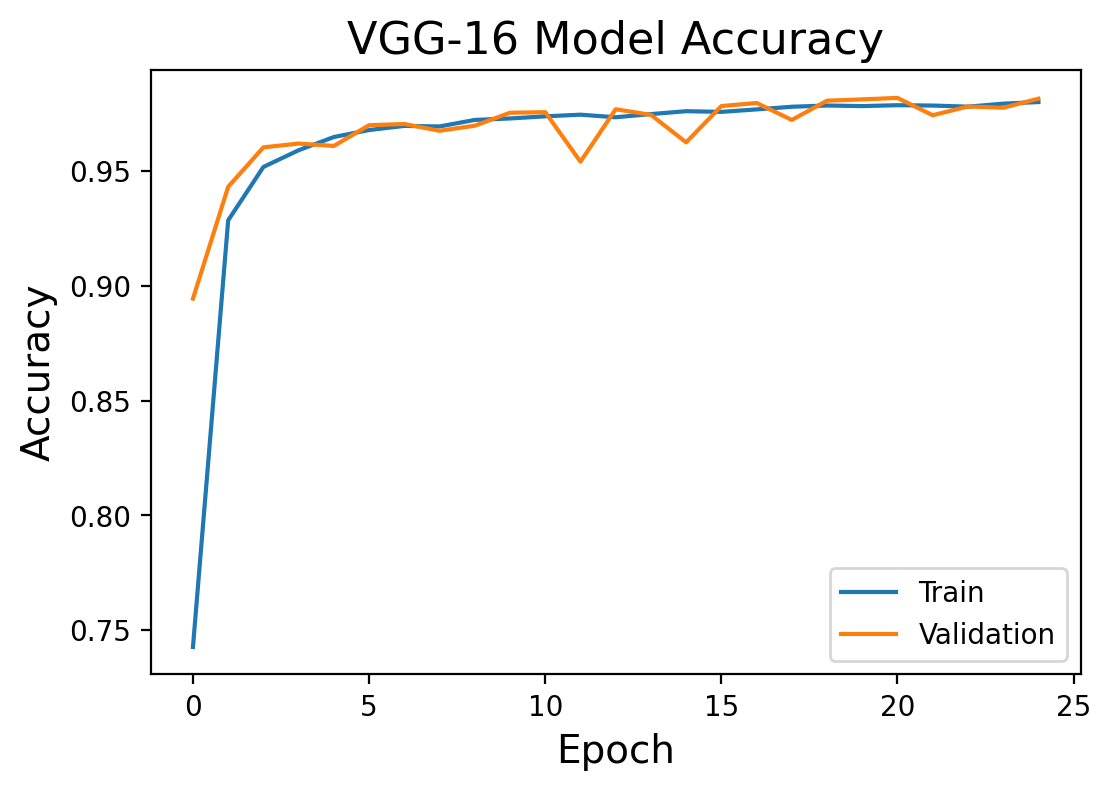

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG-16 Model Accuracy', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

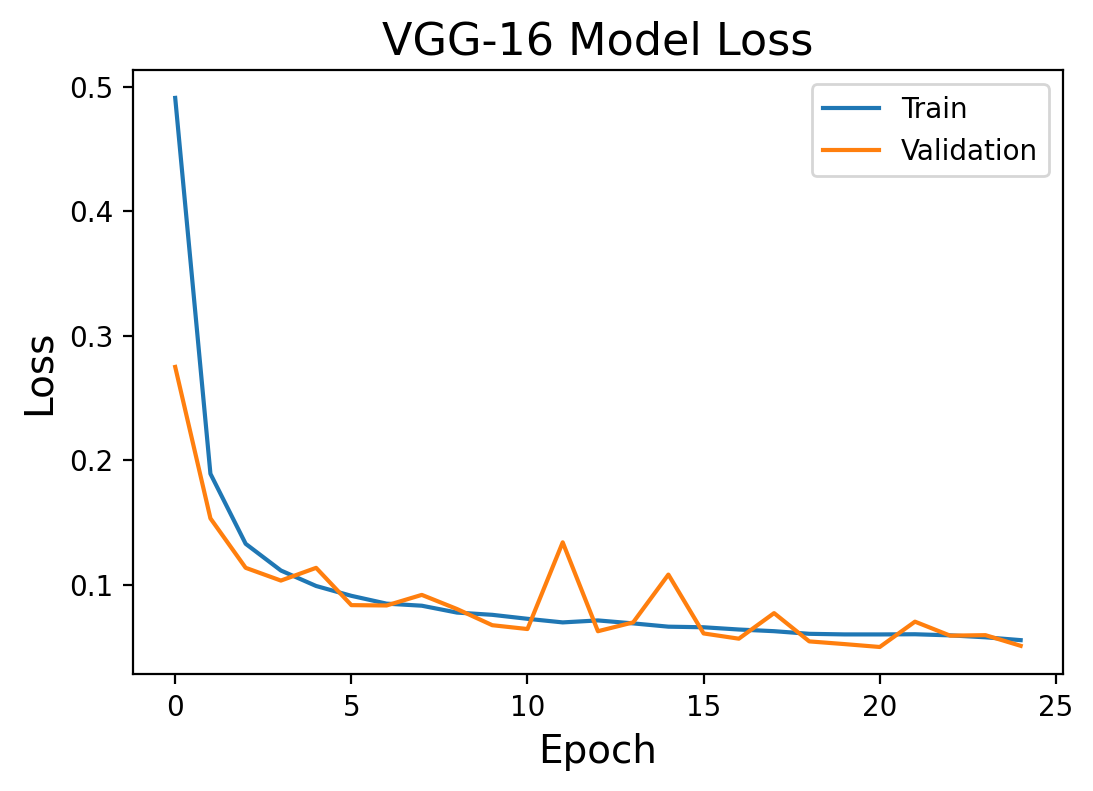

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG-16 Model Loss', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

In [40]:
TARGET_SIZE = (212, 212)
model = Sequential()
model.add(Input((*TARGET_SIZE,3)))

model.add(Conv2D(32,3,activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64,3,activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,3,activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [39]:
batch_size = 32

training_gen = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 1/3)

training_flow = training_gen.flow_from_dataframe(
    dataframe = df,
    x_col = "x",
    y_col = "y",
    batch_size = batch_size,
    target_size = TARGET_SIZE,
    class_mode = "categorical",
    subset = "training")

validation_flow = training_gen.flow_from_dataframe(
    dataframe = df,
    x_col = "x",
    y_col = "y",
    batch_size = batch_size,
    target_size = TARGET_SIZE,
    class_mode = "categorical",
    subset = "validation")

Found 46144 validated image filenames belonging to 3 classes.
Found 23072 validated image filenames belonging to 3 classes.


In [41]:
#optimizer = RMSprop(lr = 1*10**-6)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [42]:
model.fit(training_flow, validation_data = validation_flow, epochs = 1)

1442/1442 [==============================] - 1193s 827ms/step - loss: 0.6488 - accuracy: 0.6654 - val_loss: 0.6367 - val_accuracy: 0.6667


In [ ]:
batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)



model = load_model('tmp/weights.hdf5')

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    validation_data=ValBatchGenerator(fetcher),
                    nb_val_samples=val_steps_to_take,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )

In [ ]:
def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)


In [ ]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((2,2), strides=(2,2)))

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

In [ ]:
# Compile 
optimizer = RMSprop(lr=1e-6)
model = VGG_16()
model.compile(loss='mean_squared_error', optimizer=optimizer)

## Train Model

In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)


batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.
        
        
model = load_model('tmp/weights.hdf5')

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    validation_data=ValBatchGenerator(fetcher),
                    nb_val_samples=val_steps_to_take,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )

## Applying Model

In [16]:
uncertain = uncertain_df[['x']].to_numpy()

In [21]:
imgs = np.stack([np.array(load_img(i).resize((106,106))) for i in uncertain_df['x']], axis = 0)
print(imgs.shape)

(124358, 106, 106, 3)


In [22]:
classes = model.predict(imgs)

In [23]:
print(classes) #np.argmax(predictions, axis=1)

[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [0.]]


In [24]:
uncertain_df['Predicted Classes'] = classes
uncertain_df['Class Label'] = np.where(df['photos'] = 0.0 , 'Elliptical', 'Spiral')
#np.savetxt('class_predictions.txt', classes)
uncertain_df.to_csv('uncertain_galaxy_class_predictions.csv',index=False)

[69240, 52894]


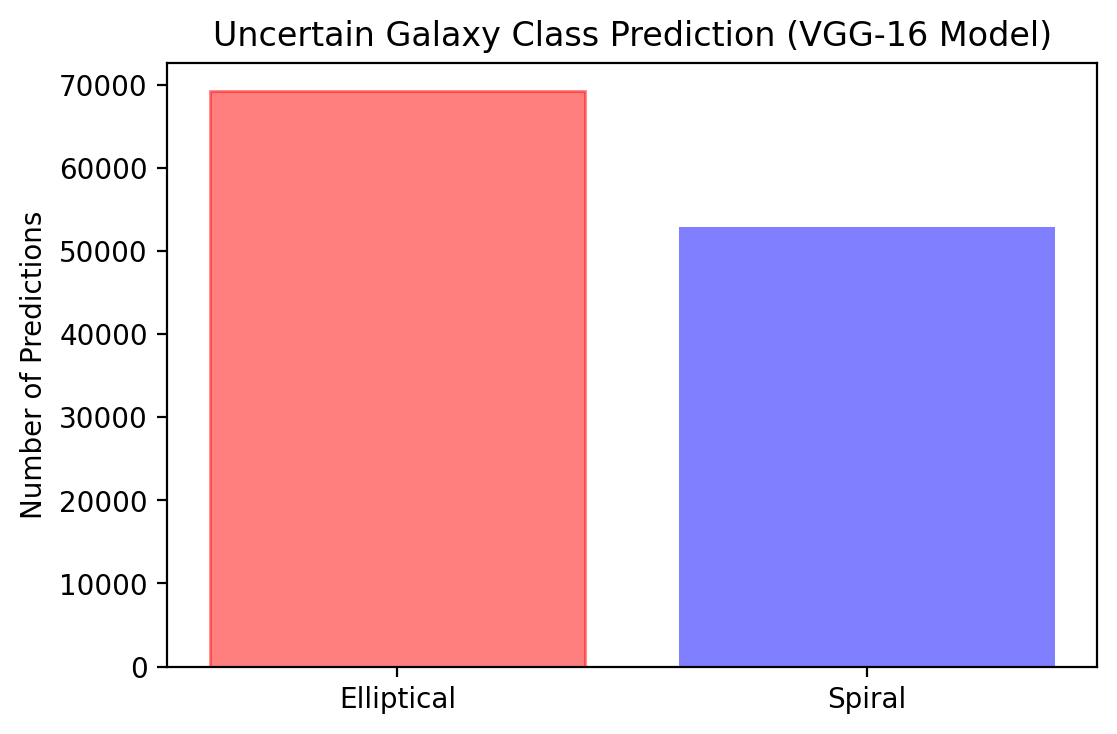

In [25]:
counts = [np.count_nonzero(classes == 0.), np.count_nonzero(classes == 1.)]
print(counts)
gal_class = ['Elliptical', 'Spiral']

barlist = plt.bar(gal_class, counts, align = 'center', color = 'blue', alpha = 0.5)
barlist[0].set_color('red')
plt.ylabel('Number of Predictions')
plt.title('Uncertain Galaxy Class Prediction (VGG-16 Model)')
plt.show()

In [26]:
label_map = (training_flow.class_indices)
print(label_map)

{'Elliptical': 0, 'Spiral': 1}


In [48]:
(unique, counts) = np.unique(classes, return_counts=True)
print((unique, counts) )

(array([0.0000000e+00, 1.2185551e-38, 1.7650919e-38, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32), array([48452,     1,     1, ...,     4,    15, 25111], dtype=int64))


In [31]:
uncertain_df['Class Label'] = np.where(uncertain_df['Predicted Classes'] == 0.0 , 'Elliptical', 'Spiral')
uncertain_df

,f,x,y,Predicted Classes,Class Label
115213,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
115214,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
115215,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
115216,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
115217,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
...,...,...,...,...,...
239566,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
239567,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
239568,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
239569,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral


In [41]:
random_sample = uncertain_df.sample(n = 16).reset_index(drop=True)
random_sample

,f,x,y,Predicted Classes,Class Label
0,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
1,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
2,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
3,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
4,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
5,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral
6,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
7,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
8,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,0.0,Elliptical
9,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,G:\Files\Ryan's\Local\Galaxy Zoo 2 Images\Imag...,Uncertain,1.0,Spiral


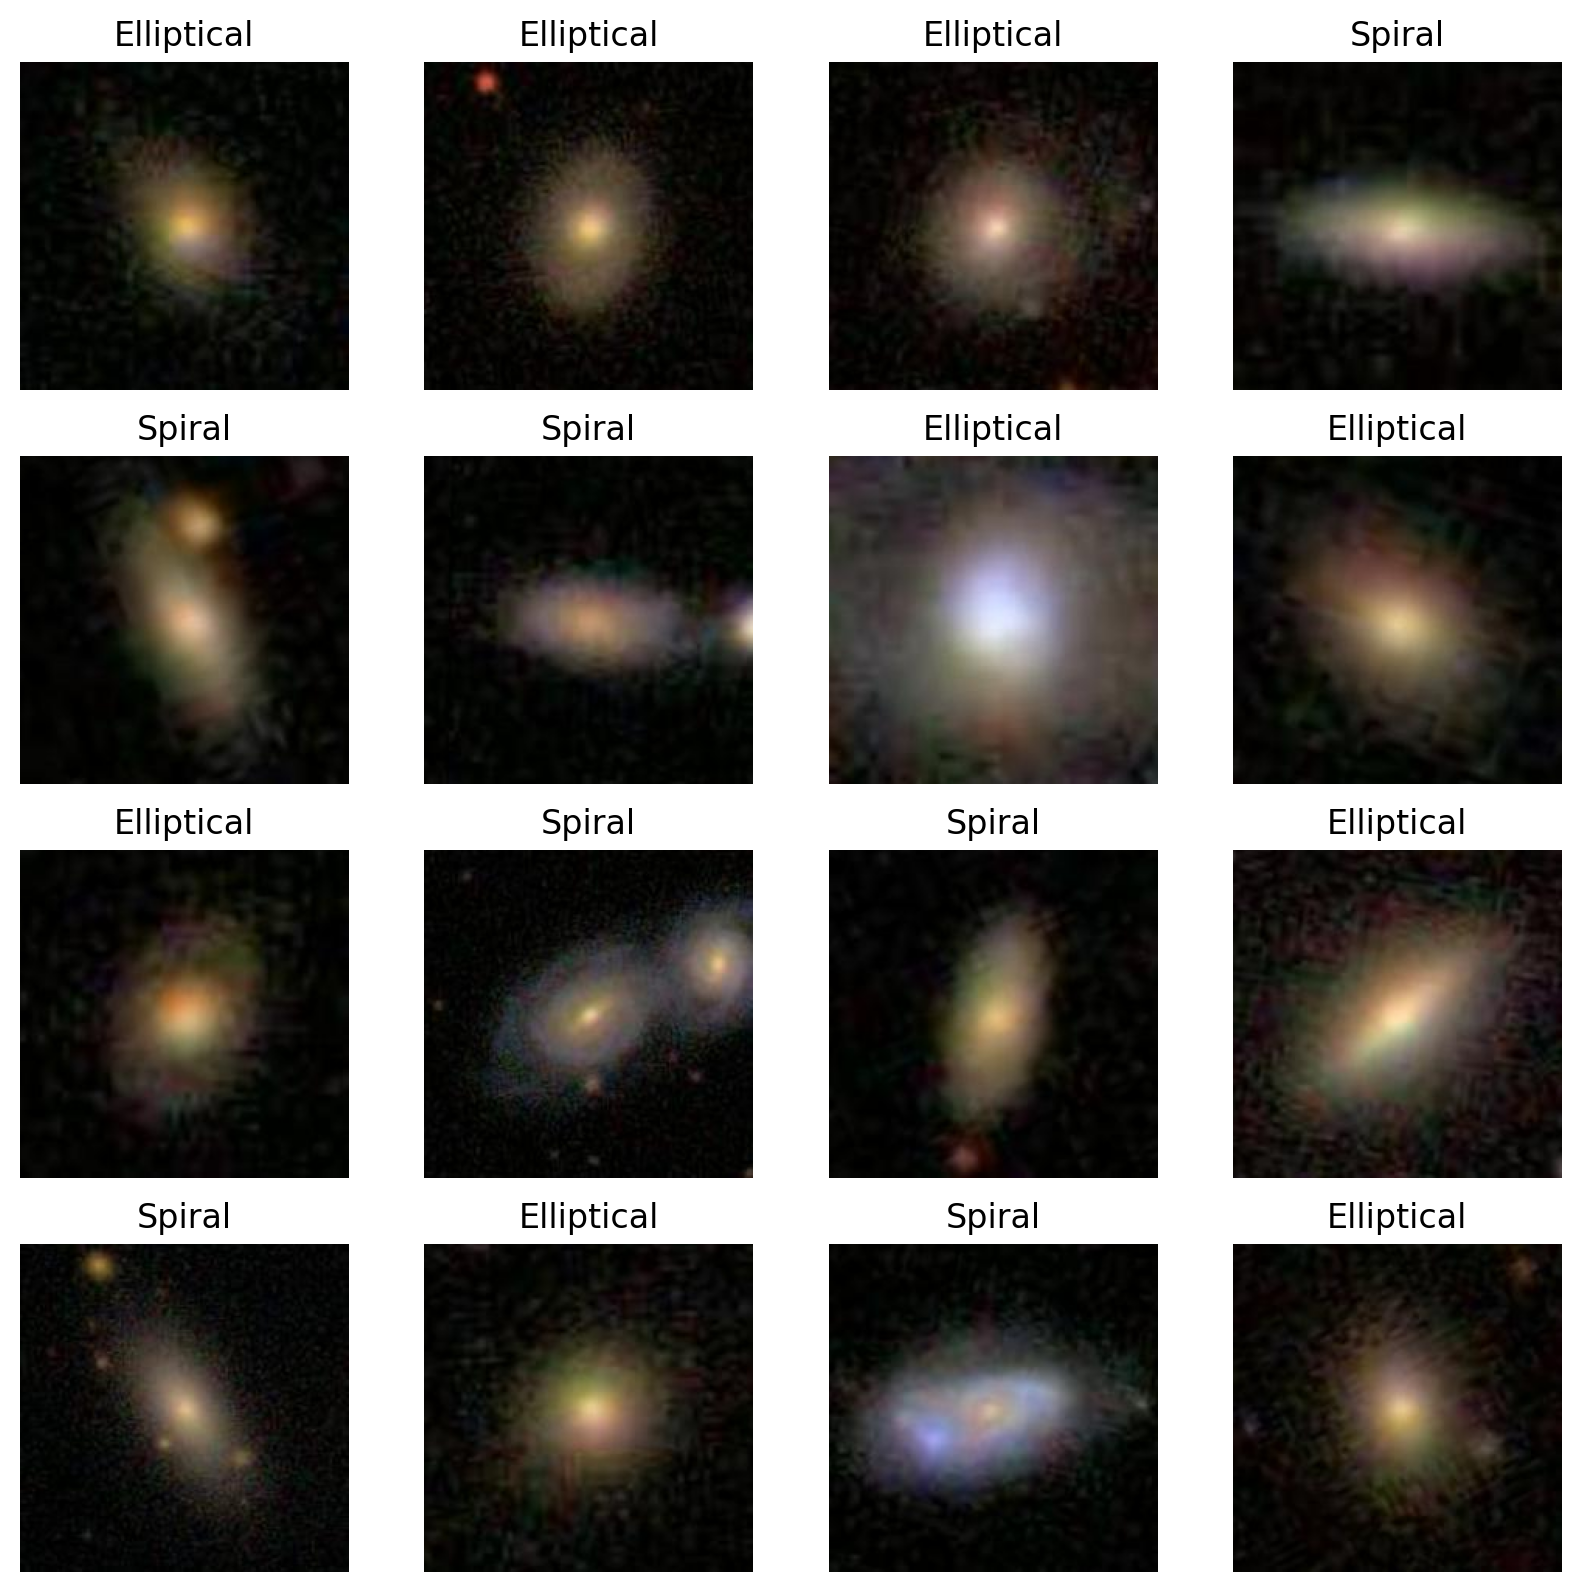

In [42]:
import matplotlib.image as mpimg

n = 4
m = 4

plt.figure(figsize=(10,10))

for i in range(n*m):
    plt.subplot(n,m,i+1)
    image = mpimg.imread(random_sample['f'][i])
    plt.imshow(image)
    plt.title(random_sample['Class Label'][i])
    plt.axis('off') 
    
plt.show()

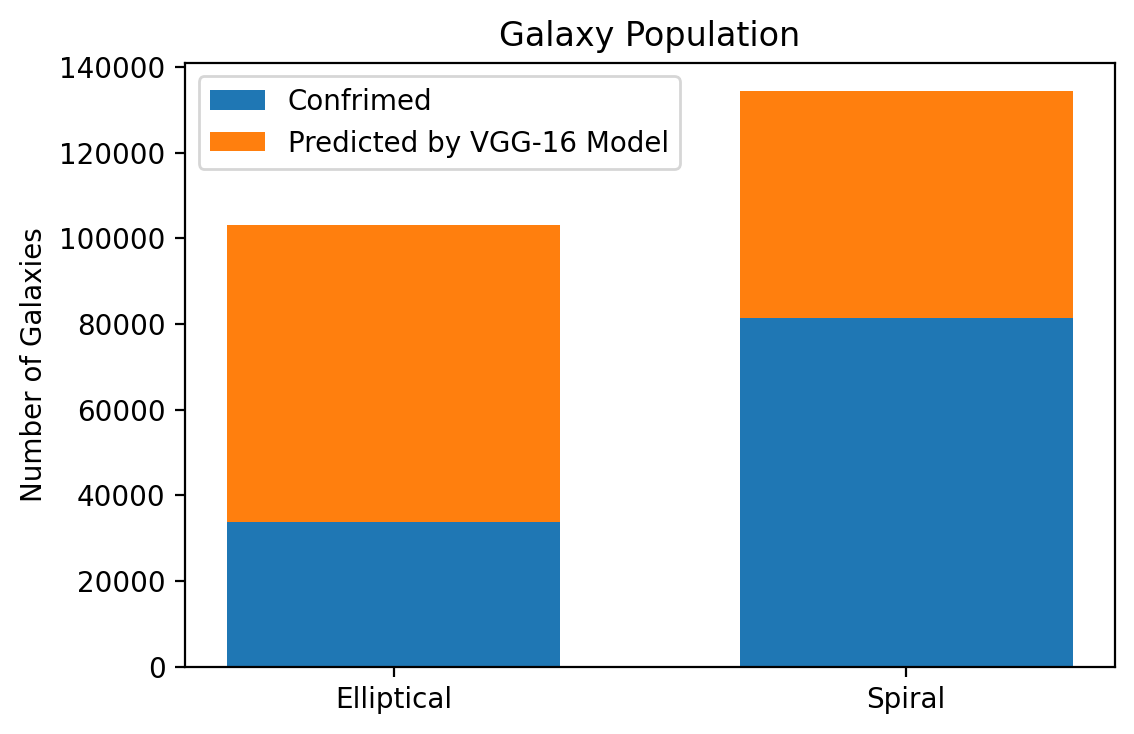

In [49]:
labels = ['Elliptical', 'Spiral']
confrimed = [33809, 81401]
guessed = [69240, 52894]
width = 0.65

fig, ax = plt.subplots()

ax.bar(labels, confrimed, width, label = 'Confrimed')
ax.bar(labels, guessed, width, bottom=confrimed, label = 'Predicted by VGG-16 Model')

ax.set_ylabel('Number of Galaxies')
ax.set_title('Galaxy Population')
ax.legend()

plt.show()

### Random Subset for testing

In [6]:
def get_random_sources(src_dir, dst_dir, n = 1000):
    '''Function to get a random number of sources from a directory and copy them into another
    '''
    file_list = os.listdir(src_dir)
    
    for j in range(n):
        a = random.choice(file_list)
        shutil.copy(src_dir + a, dst_dir + a)

In [7]:
src_dir = ["G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Images/Elliptical/", 
           "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Images/Irregular/",
           "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Images/Spiral/",
           "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Images/Uncertain/"]

dst_dir = ["G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Test/Elliptical/",
           "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Test/Irregular/",
           "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Test/Spiral/",
           "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Test/Uncertain/"]

for i in range(len(src_dir)):
    get_random_sources(src_dir[i], dst_dir[i], n=1000)

In [12]:
data_dir = "G:/Files/Ryan's/Local/Galaxy Zoo 2 Images/Images/"
gal_classes = ['Elliptical', 'Spiral', 'Irregular'] #'Uncertain'

training_set = []
training_classes = []
test_set = []
test_classes = []

for gal_type in gal_classes:
    path = pathlib.Path(data_dir+'/'+gal_type)
    
    for i, source in enumerate(path.iterdir()):
        if i>10000:
            training_set.append(str(source))
            training_classes.append(gal_type)
            
        else:
            test_set.append(str(source))
            test_classes.append(gal_type)

train_df = pd.DataFrame({"filename": training_set, "class": training_classes})
test_df = pd.DataFrame({"filename" :test_set, "class": test_classes})

'''
elif gal_type = :
    test_set.append(str(source))
    test_classes.append(gal_classes[gal_type])
'''

'\nelif gal_type = :\n    test_set.append(str(source))\n    test_classes.append(gal_classes[gal_type])\n'